- split isoforms and paralogs
- require at least two isoforms and at least two partners

In [1]:
import math

import numpy as np
from matplotlib import pyplot as plt
import pandas as pd

from data_loading import (load_isoform_and_paralog_y2h_data,
                          load_y2h_isoform_data,
                          _load_y2h_paralogs_additional_data)

In [2]:
df = load_isoform_and_paralog_y2h_data()

# could also try with valid clones dataset
df['at_least_2_isoforms'] = df['ad_gene_symbol'].map(df.loc[df['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol')['ad_clone_acc'].nunique() >= 2)

df['at_least_2_partners'] = df['ad_gene_symbol'].map(df.loc[df['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol')['db_gene_symbol'].nunique() >= 2)

In [3]:
df['at_least_1_positive_per_partner'] = (df.groupby(['ad_gene_symbol', 'db_gene_symbol'])
                                           ['score']
                                          .transform(lambda row: (row == '1').any()))
df['at_least_1_positive_per_partner'] = (df['at_least_1_positive_per_partner'] &
                                         df['ad_gene_symbol'].map(
                                             df.loc[(df['category'] == 'tf_isoform_ppis') &
                                                     df['at_least_1_positive_per_partner'],
                                                     :].groupby('ad_gene_symbol')['db_gene_symbol'].nunique() >= 2))

In [4]:
def numbers_per_cutoff(df):
    return {'N PPI': df.shape[0],
            'N TF genes': df['ad_gene_symbol'].nunique(),
            'N TF isoforms': df['ad_clone_acc'].nunique(),
            'N PPI partners': df['db_gene_symbol'].nunique()}

filtered_datasets = {'All dataset': (df.loc[df['category'] == 'tf_isoform_ppis', :]),
              'At least two isoforms per TF gene': (df.loc[(df['category'] == 'tf_isoform_ppis') &
                                                           df['at_least_2_isoforms'], :]),
              'At least two partners per TF gene': (df.loc[(df['category'] == 'tf_isoform_ppis') &
                                               df['at_least_2_isoforms'] &
                                               df['at_least_2_partners'], :]),
                'Partner is positive with at least one isoform per TF gene': (df.loc[(df['category'] == 'tf_isoform_ppis') &
                                               df['at_least_2_isoforms'] &
                                               df['at_least_2_partners'] &
                                               df['at_least_1_positive_per_partner'], :]),
              'At least one positive per isoform': load_y2h_isoform_data(require_at_least_one_ppi_per_isoform=True)}


pd.DataFrame({k: numbers_per_cutoff(v) for k, v in filtered_datasets.items()}).T

,N PPI,N TF genes,N TF isoforms,N PPI partners
All dataset,5914,164,426,907
At least two isoforms per TF gene,5538,137,399,791
At least two partners per TF gene,5447,106,308,776
Partner is positive with at least one isoform per TF gene,4578,89,260,653
At least one positive per isoform,3230,61,159,539


In [5]:
df.head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score,standard_batch,retest_pla,retest_pos,in_orfeome_screen,in_focussed_screen,in_hi_union,in_lit_bm,at_least_2_isoforms,at_least_2_partners,at_least_1_positive_per_partner
0,rrs_isoforms,100303,E2F3|2/4|10A08,E2F3,5808,HBB,0,TFr11,1,F01,False,False,False,False,True,True,False
1,tf_isoform_ppis,100588,PRRX1|3/3|09H08,PRRX1,10057,HOXA1,NC,TFr11,1,E02,False,True,False,False,True,True,False
2,tf_isoform_ppis,101431,RFX4|3/3|12B07,RFX4,10057,HOXA1,NC,TFr11,1,D02,False,True,False,False,True,True,True
3,tf_isoform_ppis,100313,TCF4|8/9|07A05,TCF4,10057,HOXA1,NC,TFr11,1,C02,False,True,False,False,True,True,True
4,tf_isoform_ppis,101026,ZBTB16|2/2|01D03,ZBTB16,10057,HOXA1,NC,TFr11,1,B02,False,True,True,False,True,True,True


In [6]:
print('Total number of isoform PPIs in current dataset before filtering:',
      (df['category'] == 'tf_isoform_ppis').sum())

Total number of isoform PPIs in current dataset before filtering: 5914


In [7]:
print('Number of isoform PPIs',
      df.loc[(df['category'] == 'tf_isoform_ppis') &
        df['at_least_2_isoforms'] &
        df['at_least_2_partners'],
       :].shape[0])

Number of isoform PPIs 5447


In [8]:
df['category'].unique()

array(['rrs_isoforms', 'tf_isoform_ppis', 'lit_bm_isoforms',
       'lit_bm_paralogs', 'tf_paralog_ppis', 'non_paralog_control',
       'rrs_paralogs', 'paralog_with_PDI'], dtype=object)

In [9]:
print('Total number of paralog (+ controls) PPIs in current dataset before filtering:',
      df['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']).sum())

Total number of paralog (+ controls) PPIs in current dataset before filtering: 7036


In [13]:
(df.loc[df['category'] == 'tf_isoform_ppis', :].groupby('ad_gene_symbol')['ad_clone_acc'].nunique() >= 2)

ad_gene_symbol
ARNT2       True
ARNTL       True
ARNTL2      True
ATF2        True
CREB1       True
           ...  
ZSCAN18     True
ZSCAN21     True
ZSCAN25    False
ZSCAN32     True
ZSCAN9      True
Name: ad_clone_acc, Length: 164, dtype: bool

In [17]:
df['standard_batch'].value_counts()

TFr08    4308
TFr07    2922
TFr09    2070
TFr10    1901
TFr12    1827
TFr11    1182
Name: standard_batch, dtype: int64

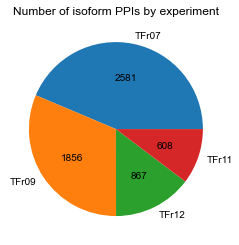

In [56]:
# pie charts
from pathlib import Path
fig_dir = Path('../figures/Y2H_QC')

df.loc[df['category'] == 'tf_isoform_ppis', 'standard_batch'].value_counts().plot.pie(autopct=lambda x: str(int(x / 100 * (df['category'] == 'tf_isoform_ppis').sum())))
plt.ylabel('')
plt.title('Number of isoform PPIs by experiment')
plt.savefig(fig_dir / 'n-ppis-by-experiment_isoforms_pie.pdf',
            bbox_inches='tight')

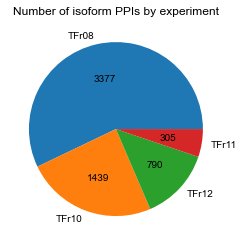

In [55]:
df.loc[df['category'].isin(['tf_paralog_ppis', 'paralog_with_PDI', 'non_paralog_control']), 'standard_batch'].value_counts().plot.pie(autopct=lambda x: str(int(x / 100 * (df['category'] == 'tf_isoform_ppis').sum())))
plt.ylabel('')
plt.title('Number of isoform PPIs by experiment')
plt.savefig(fig_dir / 'n-ppis-by-experiment_paralogs_pie.pdf',
            bbox_inches='tight')

In [18]:
# fraction / number of matrices (TF gene) all from the same experiment
df.loc[(df['category'] == 'tf_isoform_ppis') &
       df['at_least_2_isoforms'] &
       df['at_least_2_partners'], :].groupby('ad_gene_symbol')['standard_batch'].nunique().value_counts()

4    43
3    28
2    28
1     7
Name: standard_batch, dtype: int64

In [19]:
df.loc[(df['category'] == 'tf_isoform_ppis') &
       df['at_least_2_isoforms'] &
       df['at_least_2_partners'], :].groupby(['ad_gene_symbol', 'db_gene_symbol'])['standard_batch'].nunique().value_counts()

2    675
1    616
3    127
4      2
Name: standard_batch, dtype: int64

In [20]:
df.head()

,category,ad_orf_id,ad_clone_acc,ad_gene_symbol,db_orf_id,db_gene_symbol,score,standard_batch,retest_pla,retest_pos,in_orfeome_screen,in_focussed_screen,in_hi_union,in_lit_bm,at_least_2_isoforms,at_least_2_partners,at_least_1_positive_per_partner
0,rrs_isoforms,100303,E2F3|2/4|10A08,E2F3,5808,HBB,0,TFr11,1,F01,False,False,False,False,True,True,False
1,tf_isoform_ppis,100588,PRRX1|3/3|09H08,PRRX1,10057,HOXA1,NC,TFr11,1,E02,False,True,False,False,True,True,False
2,tf_isoform_ppis,101431,RFX4|3/3|12B07,RFX4,10057,HOXA1,NC,TFr11,1,D02,False,True,False,False,True,True,True
3,tf_isoform_ppis,100313,TCF4|8/9|07A05,TCF4,10057,HOXA1,NC,TFr11,1,C02,False,True,False,False,True,True,True
4,tf_isoform_ppis,101026,ZBTB16|2/2|01D03,ZBTB16,10057,HOXA1,NC,TFr11,1,B02,False,True,True,False,True,True,True


In [21]:
df = df.loc[(df['category'] == 'tf_isoform_ppis') &
        df['at_least_2_isoforms'] &
        df['at_least_2_partners'], 
        :].groupby('ad_gene_symbol')[['ad_clone_acc',
        'db_gene_symbol']].nunique().rename(columns={'ad_clone_acc': 'n_isoforms',
                                                     'db_gene_symbol': 'n_partners'}).sort_values(['n_isoforms', 'n_partners'])

In [22]:
df.head()

,n_isoforms,n_partners
ad_gene_symbol,,
ARNTL,2,2
E2F6,2,2
ETV6,2,2
FOXJ2,2,2
HSF2,2,2


In [23]:
df.tail()

,n_isoforms,n_partners
ad_gene_symbol,,
FOXP2,6,16
ZBTB44,6,20
SOX6,6,26
ZNF451,7,94
TCF4,8,181


In [61]:
df.groupby(['n_isoforms', 'n_partners']).size().to_frame().rename(columns={0: 'n_tf_genes'}).to_clipboard()

In [26]:
counts = df.groupby(['n_isoforms', 'n_partners']).size().to_frame().rename(columns={0: 'n_tf_genes'}).reset_index()
counts.head()

,n_isoforms,n_partners,n_tf_genes
0,2,2,14
1,2,3,6
2,2,4,7
3,2,6,4
4,2,7,1


In [32]:
# 7 by 12
counts.prod(axis=1).sum()

5447

In [36]:
np.round(counts.prod(axis=1).sum() / (7*12))

65.0

In [53]:
plate_count, row_count, column_count, well_count = 0, 0, 0, 0
row_max, column_max = 7, 12
plate_max = row_max * column_max
for _i, row in counts.iterrows():
    n_wells = row['n_isoforms'] * row['n_partners']
    if n_wells > plate_max:
        print(row['n_tf_genes'])
        plate_count += math.ceil(n_wells / plate_max) * row['n_tf_genes']
        continue
    for i_gene in range(1, row['n_tf_genes'] + 1):

        #if row_count + row['n_isoforms'] > row_max:
        #    if column_count + row['n_partners'] > row_max:

        if well_count + n_wells > plate_max:
            plate_count += 1
            well_count = n_wells
        else:
            well_count += n_wells
plate_count

1
1
1
1
1
1
1
1
1
1
1


75

In [56]:
# try paralogs
# try grouping paralog pairs?
df.head()

,n_isoforms,n_partners
ad_gene_symbol,,
ARNTL,2,2
E2F6,2,2
ETV6,2,2
FOXJ2,2,2
HSF2,2,2


In [49]:
df.shape

(106, 2)

In [45]:
import math

math.ceil(100 / 90)

2